# 模型微调（fine-tune)-迁移学习
- torchvision微调
- timm微调
- 半精度训练

起源：
1、随着深度学习的发展，模型的参数越来越大，许多开源模型都是在较大数据集上进行训练的，比如Imagenet-1k，Imagenet-11k等
2、如果数据集可能只有几千张，训练几千万参数的大模型，过拟合无法避免
3、如果我们想从零开始训练一个大模型，那么我们的解决办法是收集更多的数据。然而，收集和标注数据会花费大量的时间和资⾦，成本无法承受

解决方案：
- 应用迁移学习(transfer learning)，将从源数据集学到的知识迁移到目标数据集上
- 比如：ImageNet数据集的图像大多跟椅子无关，但在该数据集上训练的模型可以抽取较通用的图像特征，从而能够帮助识别边缘、纹理、形状和物体组成
- 迁移学习的一大应用场景是模型微调（finetune），就是先找到一个同类的别人训练好的模型，基于已经训练好的模型换成自己的数据，通过训练调整一下参数

不同数据集下使用微调：

数据集1 - 数据量少，但数据相似度非常高 - 在这种情况下，我们所做的只是修改最后几层或最终的softmax图层的输出类别。

数据集2 - 数据量少，数据相似度低 - 在这种情况下，我们可以冻结预训练模型的初始层（比如k层），并再次训练剩余的（n-k）层。由于新数据集的相似度较低，因此根据新数据集对较高层进行重新训练具有重要意义。

数据集3 - 数据量大，数据相似度低 - 在这种情况下，由于我们有一个大的数据集，我们的神经网络训练将会很有效。但是，由于我们的数据与用于训练我们的预训练模型的数据相比有很大不同。使用预训练模型进行的预测不会有效。因此，最好根据你的数据从头开始训练神经网络（Training from scatch）

数据集4 - 数据量大，数据相似度高 - 这是理想情况。在这种情况下，预训练模型应该是最有效的。使用模型的最好方法是保留模型的体系结构和模型的初始权重。然后，我们可以使用在预先训练的模型中的权重来重新训练该模型。

## 1、模型微调(fine-tune)一般流程：
- 1、在源数据集(如ImageNet数据集)上预训练一个神经网络模型，即源模型
- 2、创建一个新的神经网络模型，即目标模型，它复制了源模型上除了输出层外的所有模型设计及其参数
- 3、为目标模型添加一个输出⼤小为⽬标数据集类别个数的输出层，并随机初始化该层的模型参数
- 4、在目标数据集上训练目标模型。我们将从头训练输出层，而其余层的参数都是基于源模型的参数微调得到的

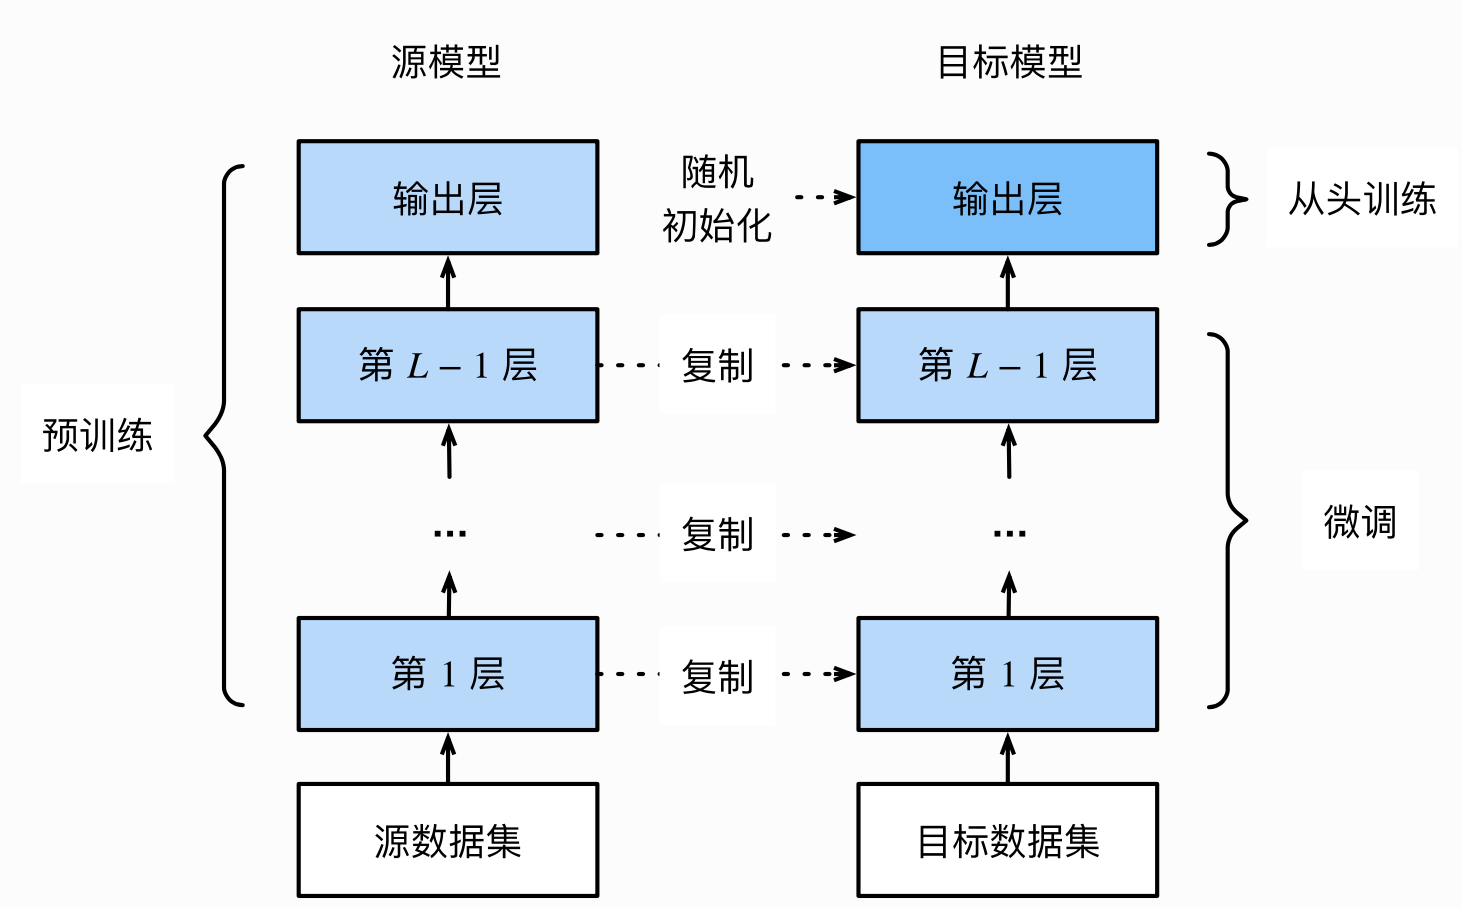

## 2、torchvision微调
### 2.1 实例化Model

```python
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True)
```

pretrained参数说明：
- 1、通过True或者False来决定是否使用预训练好的权重，在默认状态下pretrained = False，意味着我们不使用预训练得到的权重
- 2、当pretrained = True，意味着我们将使用在一些数据集上预训练得到的权重

注意：如果中途强行停止下载的话，一定要去对应路径下将权重文件删除干净，否则会报错。

### 2.2 训练特定层
如果我们正在提取特征并且只想为新初始化的层计算梯度，其他参数不进行改变。那我们就需要通过设置requires_grad = False来冻结部分层

```python
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
```

### 2.3 实例
- 使用resnet18为例的将1000类改为4类，但是仅改变最后一层的模型参数
- 我们先冻结模型参数的梯度，再对模型输出部分的全连接层进行修改



In [ ]:
import torchvision.models as models
# 冻结参数的梯度
feature_extract = True
model = models.resnet18(pretrained=True)
set_parameter_requires_grad(model, feature_extract)

# 修改模型
num_ftrs = model.fc.in_features
model.fc = nn.Linear(in_features=num_ftrs, out_features=4, bias=True)

#训练过程中，model仍会进行梯度回传，但是参数更新则只会发生在fc层

## 2、timm微调
- 安装：pip3 install timm

### 2.1、查看预训练模型

In [ ]:
import timm
avail_pretrained_models = timm.list_models(pretrained=True)
len(avail_pretrained_models)

#### 2.1.1、查看模型参数

In [ ]:
model = timm.create_model('resnet50',num_classes=10,pretrained=True)
model.default_cfg

### 2.2、修改预训练模型

In [ ]:
import timm
import torch

model = timm.create_model('resnet34',pretrained=True)
x = torch.randn(1,3,224,224)
output = model(x)
output.shape

### 2.2.1、查看某一层模型参数（以第一层卷积为例）

In [ ]:
model = timm.create_model('resnet34',pretrained=True)
list(dict(model.named_children())['conv1'].parameters())

#修改模型（将1000类改为10类输出）
model = timm.create_model('resnet34',num_classes=10,pretrained=True)
x = torch.randn(1,3,224,224)
output = model(x)
output.shape

#改变输入通道数（比如我们传入的图片是单通道的，但是模型需要的是三通道图片） 我们可以通过添加in_chans=1来改变
model = timm.create_model('resnet34',num_classes=10,pretrained=True,in_chans=1)
x = torch.randn(1,1,224,224)
output = model(x)

In [ ]:
#模型保存
torch.save(model.state_dict(),'./checkpoint/timm_model.pth')
model.load_state_dict(torch.load('./checkpoint/timm_model.pth'))

## 3、半精度训练
问题：
- GPU的性能主要分为两部分：算力和显存。
- 前者决定了显卡计算的速度，后者则决定了显卡可以同时放入多少数据用于计算
- 在可以使用的显存数量一定的情况下，每次训练能够加载的数据更多（也就是batch size更大），则也可以提高训练效率

定义：
- PyTorch默认的浮点数存储方式用的是torch.float32，小数点后位数更多固然能保证数据的精确性
- 但绝大多数场景其实并不需要这么精确，只保留一半的信息也不会影响结果，也就是使用torch.float16格式。由于数位减了一半，因此被称为“半精度”

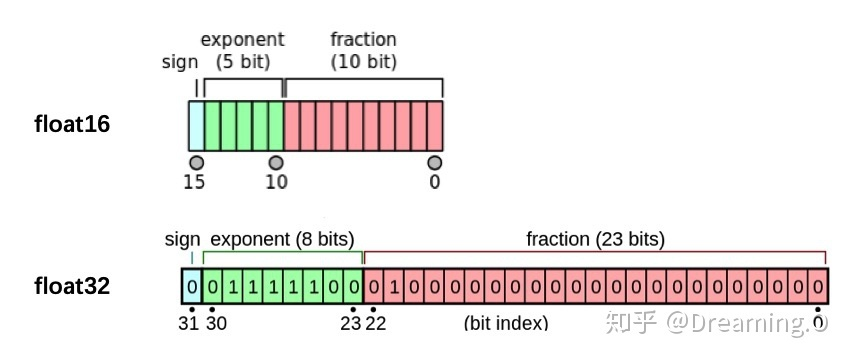

显然半精度能够减少显存占用，使得显卡可以同时加载更多数据进行计算

### 3.1、半精度训练的设置
- 1、引入 from torch.cuda.amp import autocast
- 2、forward函数指定 autocast 装饰器
- 3、训练过程： 只需在将数据输入模型及其之后的部分放入“with autocast():“
- 4、半精度训练主要适用于数据本身的size比较大（比如说3D图像、视频等）

In [ ]:
# 引入

from torch.cuda.amp import autocast

```python
# forward指定装饰器
@autocast()   
def forward(self, x):
    ...
    return x
```

```python
# 指定with autocast 
 for x in train_loader:
	x = x.cuda()
	with autocast():
            output = model(x)
        ...
```